**Limpieza y analisis de informacion**

In [1]:
import pandas as pd
#Paso el archivo del dataset a un dataframe de pandas para manejar la informacion
df = pd.read_csv("Dataset - Hoja 1.csv")
df

,Texto,Sentimiento
0,"El sabor es increíble, lo mejor que he probado",positivo
1,Llegó tarde y el paquete estaba dañado,negativo
2,El precio es razonable para la calidad,positivo
3,Los precios son razonables para la calidad,positivo
4,No noto diferencia con otros productos similares,neutral
...,...,...
295,Me siento con más vitalidad desde que lo uso,positivo
296,"Excelente calidad, vale cada centavo",positivo
297,"El sabor es aceptable, pero no sorprendente",neutral
298,Tuve problemas con la atención al cliente,negativo


In [2]:
sentimientos = df['Sentimiento'].value_counts()
sentimientos

Sentimiento
positivo    130
negativo     97
neutral      73
Name: count, dtype: int64

In [3]:
#Por las dudas paso un isna() para ver si hay datos faltantes
df.isna().sum()

Texto          0
Sentimiento    0
dtype: int64

**Tokenizacion y generacion de embeddings**

In [4]:
#Al no necesitar limpieza porque estamos usando un modelo de embeddings preentrenados, paso directamente a la tokenizacion y generacion de los embeddings
#Importo las librerias y funciones necesarias para los embeddings
import torch.nn.functional as F
from torch import Tensor
from transformers import AutoTokenizer, AutoModel

def average_pool(last_hidden_states: Tensor,
                 attention_mask: Tensor) -> Tensor:
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

In [5]:
#Agrego "query: " adelante de cada texto del dataframe
df["Texto"] = "query: " + df["Texto"]
df 

,Texto,Sentimiento
0,"query: El sabor es increíble, lo mejor que he ...",positivo
1,query: Llegó tarde y el paquete estaba dañado,negativo
2,query: El precio es razonable para la calidad,positivo
3,query: Los precios son razonables para la calidad,positivo
4,query: No noto diferencia con otros productos ...,neutral
...,...,...
295,query: Me siento con más vitalidad desde que l...,positivo
296,"query: Excelente calidad, vale cada centavo",positivo
297,"query: El sabor es aceptable, pero no sorprend...",neutral
298,query: Tuve problemas con la atención al cliente,negativo


In [6]:
#Cargo el tokenizador y el modelo
tokenizer = AutoTokenizer.from_pretrained('intfloat/multilingual-e5-large')
model = AutoModel.from_pretrained('intfloat/multilingual-e5-large')

In [7]:
#Paso los textos a una lista para tokenizarlos
textos = df['Texto'].tolist()

In [8]:
#Tokenizo los textos del dataframe
batch_dict = tokenizer(textos, max_length=512, padding=True, truncation=True, return_tensors='pt')

In [9]:
#Una vez tokenizados los paso por el modelo
outputs = model(**batch_dict)
embeddings = average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])

In [10]:
#Normalizo los embeddings
embeddings = F.normalize(embeddings, p=2, dim=1)
scores = (embeddings[:2] @ embeddings[2:].T) * 100
print(scores.tolist())

[[86.89205169677734, 87.19795989990234, 87.013427734375, 87.10462951660156, 86.62528991699219, 88.32530975341797, 86.99253845214844, 89.39677429199219, 90.11628723144531, 82.24622344970703, 87.12083435058594, 88.3935546875, 85.67961883544922, 86.12478637695312, 82.92826080322266, 87.99679565429688, 87.21117401123047, 88.67103576660156, 82.66676330566406, 85.7509536743164, 89.27733612060547, 87.50399017333984, 85.40247344970703, 83.08773803710938, 86.6106948852539, 82.90017700195312, 90.24420928955078, 90.11559295654297, 86.31423950195312, 86.49652862548828, 87.25048828125, 88.21665954589844, 92.41960906982422, 88.38158416748047, 85.36778259277344, 85.61143493652344, 83.97447204589844, 86.89315032958984, 88.8727035522461, 84.72881317138672, 93.02484893798828, 85.90042877197266, 84.11079406738281, 88.3346939086914, 81.55099487304688, 87.66663360595703, 89.30640411376953, 87.03776550292969, 95.20616149902344, 82.14788055419922, 89.10870361328125, 88.35499572753906, 85.74424743652344, 88.3

In [11]:
#Me aseguro de tener 300 embeddings, tengo 300 embeddings y el numero de dimensiones que tiene cada uno es de 1024 (osea la longitud que representa cada texto)
embeddings.shape

torch.Size([300, 1024])

In [12]:
#Me aseguro de que los embeddings tengan la forma que buscaba
embeddings

tensor([[ 0.0214, -0.0067, -0.0165,  ..., -0.0008, -0.0440,  0.0254],
        [ 0.0060, -0.0072,  0.0099,  ..., -0.0120, -0.0515, -0.0162],
        [ 0.0154, -0.0209, -0.0151,  ...,  0.0104, -0.0401,  0.0016],
        ...,
        [ 0.0121, -0.0129, -0.0115,  ...,  0.0121, -0.0570,  0.0172],
        [ 0.0051, -0.0326, -0.0148,  ..., -0.0064, -0.0479,  0.0039],
        [ 0.0239, -0.0010, -0.0229,  ...,  0.0115, -0.0545, -0.0052]],
       grad_fn=<DivBackward0>)

**Clasificador de sentimientos    
Algoritmo propuesto: KNN**

In [13]:
#Para el metodo de clasificacion de sentimientos voy a usar el algoritmo K-NEAREST NEIGHBORS(KNN), que es un algoritmo de aprendizaje no supervisado que se va a ajustar bien a mi dataset.
#Voy a separar el conjunto de datos en 80% para el entrenamiento y 20% para el testeo
#Para entrenar el modelo al ser no parametrico, es flexible y simplemente se basa en guardar los datos. El algoritmo es facil de implementar y no se ve afectado por outliers.

In [14]:
#Voy a eliminar el prefijo "query" de los textos para ver como afecta a mi implementacion
df_sin_query = df['Texto'] = df['Texto'].str.replace('^query: ', '', regex=True)

In [15]:
#Implementacion de KNN 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import torch

#Obtengo las etiquetas de Sentimiento
labels = df["Sentimiento"].tolist()

#Divido los datos en conjunto de entrenamiento: 80%, y conjunto de prueba: 20%
X_train, X_test, y_train, y_test = train_test_split(embeddings.detach().numpy(), labels, test_size=0.2, random_state=14)

#Inicializo el clasificador KNN
knn = KNeighborsClassifier(n_neighbors=6)

#Entreno el modelo
knn.fit(X_train,y_train)

#Realizo las predicciones sobre el conjunto de prueba
y_pred = knn.predict(X_test)

#Evaluo el modelo
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9833333333333333
Classification Report:
               precision    recall  f1-score   support

    negativo       0.95      1.00      0.97        18
     neutral       1.00      0.92      0.96        12
    positivo       1.00      1.00      1.00        30

    accuracy                           0.98        60
   macro avg       0.98      0.97      0.98        60
weighted avg       0.98      0.98      0.98        60



Conclusion del clasificador: Predijo el 98% de los casos correctamente, un resultado muy bueno.  
Quizas podria mejorarse los casos donde predijo modelos neutrales ya que se comio algunos falsos neutrales en el calculo, pero en general las predicciones del clasificador son muy buenas.  

**Clustering  
Algoritmo propuesto: DBSCAN**

In [17]:
#Para el clusterizador voy a usar el algoritmo DBSCAN (Density-Based Spatial Clustering of Applications with Noise), que es un algoritmo de clustering basado en la densidad.
#Es util para mi dataset ya que no se la cantidad de clusters que voy a tener o necesitar y este algoritmo me los genera por si solos no como otros como K-MEANS.

In [18]:
#Estaba teniendo problemas usando clustering sin reducir la dimensionalidad de los embeddings. Voy a usar un algoritmo para probar si haciendo eso mejora mi clusterizador

In [19]:
#Convierto los embeddings a numpy
embeddings_np = embeddings.detach().numpy()

In [20]:
#Aplico PCA para reducir la dimensionalidad
from sklearn.decomposition import PCA
pca = PCA(n_components=0.85) #Elijo la cantidad de componentes que explican al menos el 85% de la varianza
embeddings_pca = pca.fit_transform(embeddings.detach().numpy())
print(embeddings_pca.shape) #Imprimo la forma de los embeddings para ver a cuantas dimensiones se reducieron y se quedaron con el 85% de la varianza

(300, 42)


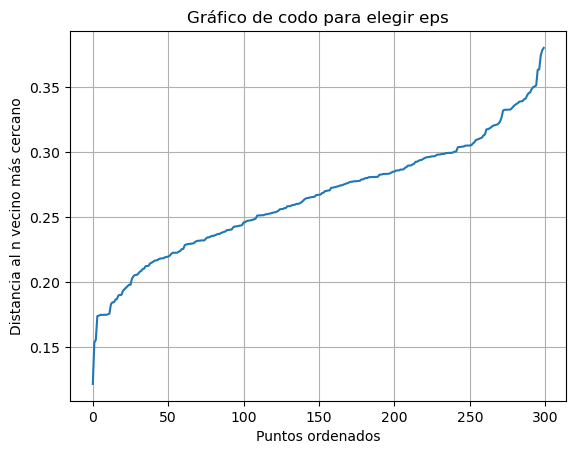

In [21]:
#Grafico de codo para analizar donde deberia tomar el eps
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

X_pca = embeddings_pca
neighbors = NearestNeighbors(n_neighbors=5)  
neighbors_fit = neighbors.fit(X_pca)
distances, indices = neighbors_fit.kneighbors(X_pca)

distances = np.sort(distances[:, 4]) #extraigo y ordeno las distancias al 5to vecino mas cercano (el slice es en 4 xq los indices arrancan en 0)
plt.plot(distances)
plt.ylabel("Distancia al n vecino más cercano")
plt.xlabel("Puntos ordenados")
plt.title("Gráfico de codo para elegir eps")
plt.grid(True)
plt.show()

In [22]:
#Implementacion de dbscan
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps = 0.29, min_samples=7, metric='euclidean')
labels_dbscan = dbscan.fit_predict(embeddings_pca)

In [23]:
#Reviso la cantidad de outliers
outliers_dbscan = np.sum(labels_dbscan == -1)
outliers_dbscan

75

In [24]:
#Finalmente mejoro, pude reducir la cantidad de outliers

In [25]:
#Armo una columna clusters en mi df para identificar a que cluster pertenece cada texto
df['clusters'] = labels_dbscan

In [26]:
#Veo que tipo de comentarios son los outliers, ahora voy a calcular la cantidad de distintos sentimientos que hay. Osea cuantos positivos, negativos y neutrales hay.
outliers = df[df['clusters'] == -1]

In [27]:
conteo_sentimientos = outliers['Sentimiento'].value_counts()
conteo_sentimientos

Sentimiento
negativo    33
neutral     21
positivo    21
Name: count, dtype: int64

In [28]:
#Armo una columna clusters dentro de mi dataframe
df["clusters"] = labels_dbscan
df.head()

,Texto,Sentimiento,clusters
0,"El sabor es increíble, lo mejor que he probado",positivo,0
1,Llegó tarde y el paquete estaba dañado,negativo,-1
2,El precio es razonable para la calidad,positivo,1
3,Los precios son razonables para la calidad,positivo,1
4,No noto diferencia con otros productos similares,neutral,-1


In [29]:
#Cantidad de textos por clusters
conteo_clusters = df['clusters'].value_counts().sort_index()
conteo_clusters

clusters
-1     75
 0    138
 1     38
 2     17
 3     20
 4     12
Name: count, dtype: int64

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
stopwords_es = stopwords.words('spanish')

#Crear un vectorizador
vectorizer = TfidfVectorizer(max_features=1000, stop_words=stopwords_es) #Transforma los textos a una matriz, considerando como maximo 1000 palabras distintas y excluye las stopwords

#Diccionario para guardar resultados
top_palabras_por_cluster = {}

#Iterar por cada cluster y saltea si es un outlier o el cluster tiene menos de 2 textos
for cluster_id in sorted(df["clusters"].unique()):
    if cluster_id == -1:
        continue  

    textos = df[df["clusters"] == cluster_id]["Texto"].tolist()
    if len(textos) < 2:
        continue  

    X = vectorizer.fit_transform(textos)
    palabras = vectorizer.get_feature_names_out()
    tfidf_mean = X.mean(axis=0).A1  #Calcula el promedio de cada termino, que tan representativa es la palabra 

    top_indices = tfidf_mean.argsort()[::-1][:10] #Se queda con los 10 terminos mas representativos 
    top_words = [palabras[i] for i in top_indices]

    top_palabras_por_cluster[cluster_id] = top_words

#Mostrar resultados
for cluster_id, words in top_palabras_por_cluster.items():
    print(f"\nCluster {cluster_id}:") #Imprime las 10 palabras principales del cluster
    print(", ".join(words))


Cluster 0:
sabor, llegó, producto, calidad, envío, esperaba, mejor, satisfecho, rápido, bien

Cluster 1:
precio, calidad, razonable, ofrece, caro, producto, demasiado, justo, alto, encima

Cluster 2:
servicio, cliente, excelente, atención, amable, rápido, ayudaron, problema, buen, profesional

Cluster 3:
servicio, cliente, atención, problema, resolvió, dudas, lento, gustó, nadie, trato

Cluster 4:
causó, recomiendo, estomacal, después, tomarlo, hinchazón, molestias, estomacales, insomnio, principio


Analisis de los clusters  
Cluster 0: Temas mezclados pero positivos/neutrales en tono: habla de sabor, calidad, experiencia de compra y envío. Es razonable que sea el cluster mas grande pues abarca mucha experiencia de usuario en general  
Cluster 1: Muy claro: percepción del precio y valor. Bien diferenciado de los demas, puede tener una mezcla de positivos y negativos  
Cluster 2: Claramente postivo en torno a la atencion al cliente. Comentarios de agradecimiento y satisfaccion  
Cluster 3: Claramente negativo, pero sobre el mismo tema que el cluster 2. Mismo tema pero desde el lado negativo  
Cluster 4: Muy específico: efectos secundarios o reacciones negativas al producto. Perfecto como cluster pequeño pero crítico. Información valiosa para control de calidad o regulaciones.  

En tema de la cantidad de sentimientos calculados anteriormente, estos clusters encajan bastante bien en la cantidad de sentimientos de los Textos.  
Clusters 0, 1 y 2, abarcarian los sentimientos positivos y neutros. Los clusters 3 y 4 los negativos.  
#Hay que ver que hago con los outliers, si los pongo en donde va la mayoria de comentarios o que hacer.  

**Clasificacion de outliers**

In [32]:
#Para los outliers voy a calcular su distancia al cluster mas cercano y si cumplen cierto umbral de distancia los agrego al mismo. Porque si no terminan perdiendo sentido los clusters
#Si no cumplen el umbral quedan como outliers, voy a probar si asi puedo bajar la cantidad de estos
#Esta estrategia no me sirvio, ya que se me reasignaban todos los outliers y algunos de ellos estaban en grupos que no debian pertenecer

In [33]:
outliers

,Texto,Sentimiento,clusters
1,Llegó tarde y el paquete estaba dañado,negativo,-1
4,No noto diferencia con otros productos similares,neutral,-1
6,No recomendaría este producto a nadie,negativo,-1
13,El sabor es artificial y desagradable,negativo,-1
16,El producto llegó tarde y sin aviso previo,negativo,-1
...,...,...,...
276,"Me atendieron bien, pero tardaron en resolver ...",neutral,-1
285,Creo que el precio podría ajustarse un poco más,neutral,-1
288,"No recomendaría esta tienda, mala atención",negativo,-1
295,Me siento con más vitalidad desde que lo uso,positivo,-1


Lo que se puede analizar de estos datos es que por ejemplo los sentimientos negativo y positivo estan llevados a lo extremo, gente que recomienda o no el producto fervientemente.  
Mientras que los neutrales son comentarios que utilizan palabras como promedio, son extremadamente neutrales, medio que no te dicen nada ni si es bueno o malo el producto. Pero algunos tienen una tendencia a ser mas negativos.  
Mi siguiente estrategia seria armar 3 clusters mas, manualmente, donde clasificaria estos comentarios extremos.

In [35]:
#Aquellos comentarios que entren en outliers y sean positivos los asigno al cluster 5, ya que tienen en comun ser comentarios extremadamente positivos
df.loc[(df['clusters'] == -1) & (df['Sentimiento'] == 'positivo'), 'clusters'] = 5

In [36]:
#Los negativos al 6
df.loc[(df['clusters'] == -1) & (df['Sentimiento'] == 'negativo'), 'clusters'] = 6

In [37]:
#Los neutrales al 7
df.loc[(df['clusters'] == -1) & (df['Sentimiento'] == 'neutral'), 'clusters'] = 7

In [38]:
#Voy a mapear los clusters con sus topicos para tematizarlos
#Armo un diccionario
temas_clusters = {
    0: 'experiencia general positiva/neutral',
    1: 'percepcion del precio y relacion valor-calidad',
    2: 'atencion al cliente positiva',
    3: 'atencion al cliente negativa',
    4: 'efectos secundarios o problemas con el producto',
    5: 'comentario muy positivo',
    6: 'comentario muy negativo',
    7: 'comentario sin un sentimiento claro'
}

In [39]:
df['Tema'] = df['clusters'].map(temas_clusters)
df

,Texto,Sentimiento,clusters,Tema
0,"El sabor es increíble, lo mejor que he probado",positivo,0,experiencia general positiva/neutral
1,Llegó tarde y el paquete estaba dañado,negativo,6,comentario muy negativo
2,El precio es razonable para la calidad,positivo,1,percepcion del precio y relacion valor-calidad
3,Los precios son razonables para la calidad,positivo,1,percepcion del precio y relacion valor-calidad
4,No noto diferencia con otros productos similares,neutral,7,comentario sin un sentimiento claro
...,...,...,...,...
295,Me siento con más vitalidad desde que lo uso,positivo,5,comentario muy positivo
296,"Excelente calidad, vale cada centavo",positivo,5,comentario muy positivo
297,"El sabor es aceptable, pero no sorprendente",neutral,0,experiencia general positiva/neutral
298,Tuve problemas con la atención al cliente,negativo,3,atencion al cliente negativa


In [40]:
df = df.drop('clusters', axis = 1)

Asi finalizariamos con la clusterizacion de los textos, y no perderiamos ninguna opinion que sea util para el analisis posterior

**Modelado de IA generativa**

In [42]:
#Vamos a seguir con la parte del modelado de IA generativa, para esto vamos a usar groq que es una plataforma que permite utilizar LLMs Open Source de manera gratuita a través de una API

In [43]:
import requests
import time

groq_api_key = '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'

def generar_respuesta(texto, sentimiento, tema):
    system_prompt = (
        "Sos un asistente de atención al cliente. Respondé comentarios de forma profesional, teniendo en cuenta el sentimiento del mensaje y el tema detectado. Sé empático si el cliente está molesto, y cordial si está satisfecho."
    )
    
    user_prompt = (                 
        f"Comentario del cliente: '{texto}' "
        f"Sentimiento: {sentimiento} "
        f"Tema: {tema} "
        "Generá una respuesta adecuada para este cliente."
    )

    url = "https://api.groq.com/openai/v1/chat/completions"
    headers = {
        "Authorization": f"Bearer {groq_api_key}",
        "Content-Type": "application/json"
    }

    data = {
        "model": "llama3-70b-8192",
        "messages": [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ]
    }

    response = requests.post(url, headers=headers, json=data)
    
    if response.status_code == 200:
        return response.json()['choices'][0]['message']['content'].strip()
    else:
        print("Error:", response.status_code, response.text)
        return "Error al generar respuesta"

La funcion generar_respuesta se encarga de generar automaticamente respuestas al feedback de los clientes, usando LLaMA 3 como modelo de lenguaje y los datos que usa son mi df.  
Defino el prompt del sistema, como quiero que se comporte el modelo y le da un contexto general de lo que tiene que hacer.  
Despues defino el prompt del usuario, que no es mas que cargar los datos del dataframe, y darle una orden al modelo de que hacer con esos datos.  
Despues cargo la url de donde estoy mandando la solicitud para generar la respuesta. Y le cargo mi informacion con mi key y los tipos de datos que estoy mandando (en este caso datos en formato JSON que son los que la API entiende)  
En la parte de data defino el modelo y los mensajes que le mando a la API. Su funcionamiento es que el modelo "simula" un dialogo y da una respuesta para ese texto en particular.  
Le envia el request con los prompts al modelo y espera la respuesta.   
Finalmente extrae el texto generado. Primero verifica si la respuesta fue correcta igualando un codigo a 200, si es asi sigue, si no devuelve error con un mensaje fijo.   
response.json lo que hace es traducir el mensaje recibido desde GROQ a un diccionario de python.    
Choices da una lista con posibles respuestas, con [0] elijo la primera, en message accedo al texto generado y content me da el mensaje que realmente quiero mostrar, el strip() es para eliminar espacios en blanco que no quiero.  

In [45]:
#Lo aplico al dataframe

respuestas = []

for idx, row in df.iterrows(): #indice de la fila, y una serie de pandas con los datos en la fila
    respuesta = generar_respuesta( #llamo a la funcion, pasandole el texto del usuario, el sentimiento y el tema
        texto=row['Texto'],
        sentimiento=row['Sentimiento'],
        tema=row['Tema']
    )
    respuestas.append(respuesta) #appendea a la lista el mensaje generado por la ia
    time.sleep(2.1)  #el time sleep es para evitar el rate limit, y asi poder imprimir todos los texots.

df['Respuesta IA'] = respuestas #pongo la lista como una columna del df

In [46]:
df

,Texto,Sentimiento,Tema,Respuesta IA
0,"El sabor es increíble, lo mejor que he probado",positivo,experiencia general positiva/neutral,¡Muchas gracias por compartir tu experiencia c...
1,Llegó tarde y el paquete estaba dañado,negativo,comentario muy negativo,Lo siento mucho. Lamento que el paquete haya l...
2,El precio es razonable para la calidad,positivo,percepcion del precio y relacion valor-calidad,¡Muchas gracias por compartir tus thoughts sob...
3,Los precios son razonables para la calidad,positivo,percepcion del precio y relacion valor-calidad,"""¡Muchas gracias por compartir tu experiencia ..."
4,No noto diferencia con otros productos similares,neutral,comentario sin un sentimiento claro,¡Hola! Gracias por compartir tus pensamientos ...
...,...,...,...,...
295,Me siento con más vitalidad desde que lo uso,positivo,comentario muy positivo,¡Es fantástico que hayas experimentado un aume...
296,"Excelente calidad, vale cada centavo",positivo,comentario muy positivo,¡Muchas gracias por tomar el tiempo de compart...
297,"El sabor es aceptable, pero no sorprendente",neutral,experiencia general positiva/neutral,¡Hola! Gracias por compartir tus pensamientos ...
298,Tuve problemas con la atención al cliente,negativo,atencion al cliente negativa,"Lo siento mucho, lamentamos que hayas tenido c..."


In [47]:
from sklearn.metrics.pairwise import cosine_similarity
#Funciónes para obtener el embedding del texto, el sentimiento y la tematica
def obtener_embedding(texto):
    #Agregar 'query' al principio del texto
    texto_con_query = "query: " + texto
    
    #Tokenizar el texto
    batch_dict = tokenizer(texto_con_query, max_length=512, padding=True, truncation=True, return_tensors='pt')
    
    #Pasar el texto tokenizado al modelo
    outputs = model(**batch_dict)
    embeddings = average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])
    embeddings = F.normalize(embeddings, p=2, dim=1)
    return embeddings



def obtener_sentimiento(embedding_texto):
    sentimiento = knn.predict(embedding_texto.detach().numpy())
    return sentimiento



def obtener_tema(embedding_texto):
    similitudes = cosine_similarity(embedding_texto.detach().numpy(), embeddings.detach().numpy())[0] #comparo la similitud del coseno con los embeddings originales
    indice_mas_cercano = np.argmax(similitudes) #busca el indice del embedding mas similar
    tema = labels_dbscan[indice_mas_cercano]
    if tema == -1:
        if obtener_sentimiento(embedding_texto) == 'positivo':
            tema = 5
        elif obtener_sentimiento(embedding_texto) == 'negativo':
            tema = 6
        else:
            tema = 7
    return tema



In [48]:
def respuestaTexto (texto):
    embedding = obtener_embedding(texto)
    sentimiento = obtener_sentimiento(embedding)
    print(sentimiento)
    tema = obtener_tema(embedding)
    print(temas_clusters.get(tema))
    respuesta = generar_respuesta(texto, sentimiento, tema)
    return respuesta
    

texto = 'No es un gran producto, es muy costoso'
print(respuestaTexto(texto))


['negativo']
percepcion del precio y relacion valor-calidad
"Lamento que nuestro producto no haya cumplido con sus expectativas. Entiendo que el costo es un aspecto importante en la toma de decisiones. Me gustaría saber más sobre lo que considera que falta en nuestro producto y cómo podemos mejorar. Esto nos ayudará a ofrecerle una mejor opción en el futuro. ¿Cuál es el precio ideal que estaba buscando? Estoy aquí para escuchar y ayudar."
